# Long Short Term Memory
## A simple guide using keras library 

In this tutorial we will use supernova simulations to train a Recurren Neural Network using LSTM units.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
import numpy as np
import h5py

from sklearn.model_selection import train_test_split

2022-07-31 14:37:11.234365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-31 14:37:11.234383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load data

In [2]:
filename = './data/supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'][()]
labels       = f['labels'][()]
ids          = f['sne_id'][()]

I = [1,3,32,33]
labels_new = np.array([0 if l in I else 1 for l in labels ])
multi_class = {1: 0, 2:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}
labels     = np.array([multi_class[l] for l in labels])

<img src="./img/sne_types.png" alt="Girl in a jacket" width="350" height="400"> 

Supernova classes are very unbalanced. A faster way is to group by parent class; It means that we are going to transform a multiclass problem into a binary one.

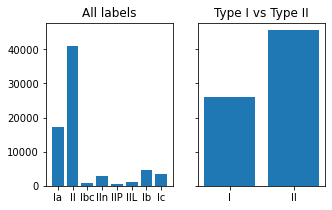

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), sharey=True)

# (labels, class names, figure title)
multi_tuple = (labels, ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic'], 'All labels')
binar_tuple = (labels_new, ['I', 'II'], 'Type I vs Type II')

for index, (y_vector, cls_names, title) in enumerate([multi_tuple, binar_tuple]):
    values, counts = np.unique(y_vector, return_counts=True)
    x_range = np.arange(len(values))
    axes[index].bar(x_range,counts)
    axes[index].set_title(title)
    axes[index].set_xticks(x_range)
    axes[index].set_xticklabels(cls_names)
    
plt.show()

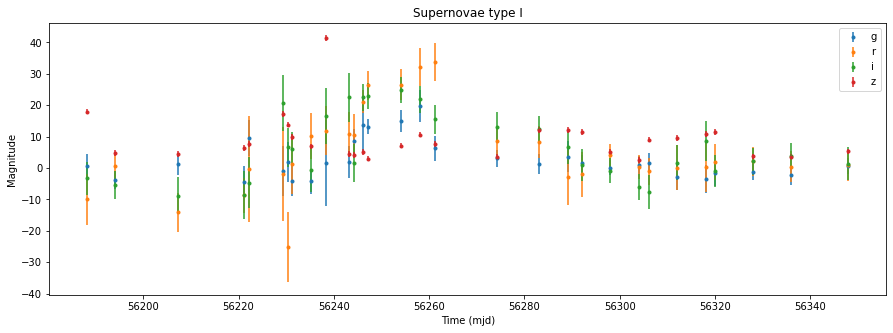

In [4]:
selected = light_curves[labels_new == 0][0]
plt.figure(figsize=(15,5))

for i, passband in enumerate(['g', 'r', 'i', 'z']):
    plt.errorbar(selected[:,0], 
                 selected[:,i+1], 
                 yerr=selected[:,i+5], 
                 label=passband, 
                 fmt='.')

plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title('Supernovae type I')
plt.show()


## Data preprocessing using tf.Data

In [5]:
INP_DIM = 9 # Number of attributes e.g., mjd, magnitudes, errors...
NUM_CLS = len(np.unique(labels_new))
BATCH_SIZE = 128 # Training batch size

In [6]:
def create_generator(list_of_arrays, labels):
    for i, j in zip(list_of_arrays, labels):
        yield {'lightcurve': i,
               'label'     : int(j),
               'mask'      : np.ones(i.shape[0])}

In [17]:
def standardize(light_curve):
    lc_means = tf.reduce_mean(light_curve, 0)
    lc_std   = tf.math.reduce_std(light_curve, 0)
    return tf.math.divide_no_nan(light_curve - tf.expand_dims(lc_means, 0), lc_std)
#     return light_curve-lc_means

def min_max_scaler(light_curve):
    lc_min   = tf.reduce_min(light_curve, 0)
    lc_max   = tf.reduce_max(light_curve, 0)
    return tf.math.divide_no_nan(light_curve - lc_min, lc_max-lc_min)

In [18]:
def preprocess(input_dict):
    light_curve = standardize(input_dict['lightcurve'])
    cat_label   = tf.one_hot(input_dict['label'], NUM_CLS)
    bool_mask   = tf.cast(input_dict['mask'], tf.bool)
    return {'x': light_curve, 'mask':bool_mask}, cat_label

In [36]:
def load_class_dataset(lightcurves, labels):
    dataset = tf.data.Dataset.from_generator(lambda: create_generator(light_curves, labels),
                                             output_types= {'lightcurve':tf.float32,
                                                            'label':tf.int32,
                                                            'mask':tf.int32},
                                             output_shapes={'lightcurve':(None, INP_DIM),
                                                            'label':(),
                                                            'mask':(None)})
    return dataset

def create_dataset(light_curves, labels, balanced=False):
    if balanced:
        datasets = []
        for y in np.unique(labels):
            cls_samples = light_curves[labels==y]
            cls_labels  = labels[labels==y]
            datasets.append(load_class_dataset(cls_samples, cls_labels))
        dataset = tf.data.Dataset.sample_from_datasets(datasets)
    else:
        dataset = load_class_dataset(light_curves, labels)
        
    dataset = dataset.map(preprocess).cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True) # shuffling in chunks of 1000 objects 
    dataset = dataset.padded_batch(BATCH_SIZE, 
                                   padded_shapes=({'x':[None, INP_DIM], 'mask':[None]}, [NUM_CLS]),
                                   drop_remainder=True
                                  )
    return dataset

In [37]:
x_train, x_rest, \
y_train, y_rest = train_test_split(light_curves, labels_new, test_size=0.5, random_state=42)

x_val, x_test, \
y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)

In [38]:
train_batches = create_dataset(x_train, y_train, balanced=True) 
valid_batches = create_dataset(x_val, y_val, balanced=True)
test_batches  = create_dataset(x_test, y_test)

2022-07-31 14:45:03.649696: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


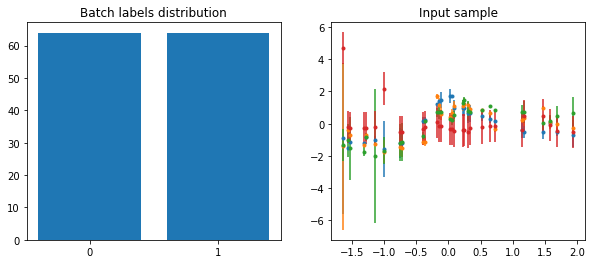

In [39]:
fig, axes  = plt.subplots(1, 2, figsize=(10,4))
for x, y in train_batches:
    un, co = np.unique(tf.argmax(y, 1), return_counts=True)
    axes[0].bar(range(len(un)), co)
    axes[0].set_xticks(range(len(un)))
    axes[0].set_xticklabels(un)
    axes[0].set_title('Batch labels distribution')
    

    masked_sample = tf.boolean_mask(x['x'][0], x['mask'][0])

    for i, passband in enumerate(['g', 'r', 'i', 'z']):
        axes[1].errorbar(masked_sample[:,0], 
                         masked_sample[:,i+1], 
                         yerr=masked_sample[:,i+5], 
                         label=passband, 
                         fmt='.')
    axes[1].set_title('Input sample')
    break

## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, Input, LayerNormalization, LSTMCell
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [41]:
# Params 
n_neurons    = 32  # Neurons in each gate of LSTM
dropout_prob = 0.3 # Fraction of the units to drop 
num_layers   = 2

In [44]:
lc_placeholder   = Input(shape=(None, INP_DIM), dtype=tf.float32)
mask_placeholder = Input(shape=(None,), dtype=tf.bool)
inputs = {
    'x': lc_placeholder, 
    'mask': mask_placeholder
}


x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs['x'])
x = LSTM(n_neurons, dropout=dropout_prob)(x)
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(NUM_CLS, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None, 9)]    0           []                               
                                                                                                  
 lstm_15 (LSTM)                 (None, None, 32)     5376        ['input_17[0][0]']               
                                                                                                  
 lstm_16 (LSTM)                 (None, 32)           8320        ['lstm_15[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 32)           1056        ['lstm_16[0][0]']                
                                                                                            

In [45]:
history = model.fit(train_batches, 
                    epochs=20,
                    callbacks = [EarlyStopping(patience=10)],
                    validation_data=valid_batches)

Epoch 1/20
    183/Unknown - 4s 15ms/step - loss: 0.6936 - acc: 0.4977

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_probas = model.predict(test_batches)
y_pred   = np.argmax(y_probas, axis=1)

y_test   = np.concatenate([y for _, y in test_batches], 0)
y_true   = np.argmax(y_test, axis=1)

acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

In [ ]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['I', 'II']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')